In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA

import sys
sys.path.append('..')

import neural_manifolds as nm

%load_ext autoreload
%autoreload 2

# Example: spikes with 2D latent model
Here, we construct spikes for $N$ neurons from time-dependent rates $\nu_i(t)$ that are linear combinations from a latend model with $z(t)$

Specifically, we choose 
$$
   z_1(t) = sin(\pi \omega t)\\
   z_2(t) = cos(\pi \omega t )
$$

(2, 5000)
{'model': <function _latent_sin_cos_model at 0x17e6c7760>,
 'model_kwargs': {'omega': 0.2},
 'type': 'sin_cos'}


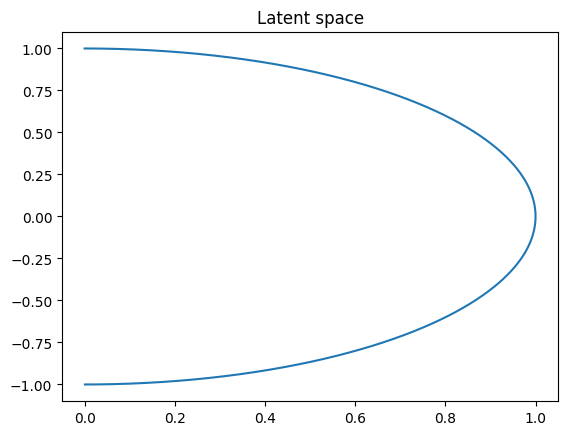

In [2]:
latent_model = nm.test_data.LatentModel("sin_cos", omega=0.2)

t = np.arange(0,5,0.001)
latent_state = latent_model(t)
print(latent_state.shape)
plt.plot(latent_state[0,:],latent_state[1,:]) 
plt.title("Latent space")
print(latent_model)

Then, we generate neural firing rates as linear combinations of the latent variables

$$
  \nu_i (t) = c_1*z_1(t) + c_2*z_2(t) + offset
$$

In [3]:
from neural_manifolds.test_data import firing_rates
# Number of neurons
N = 32
rates = firing_rates(latent_model, t, N)
print(rates.shape)

(32, 5000)


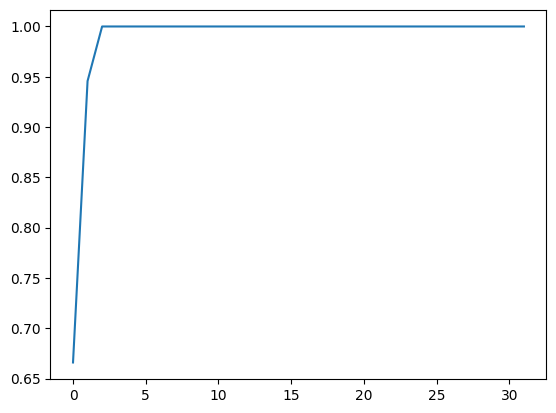

In [13]:
pca_orig = PCA()
pca_orig.fit(rates)
plt.plot(np.cumsum(pca_orig.explained_variance_ratio_))

To get a bit more realistic, let's generate actual spikes as an inhomogeneous poisson process

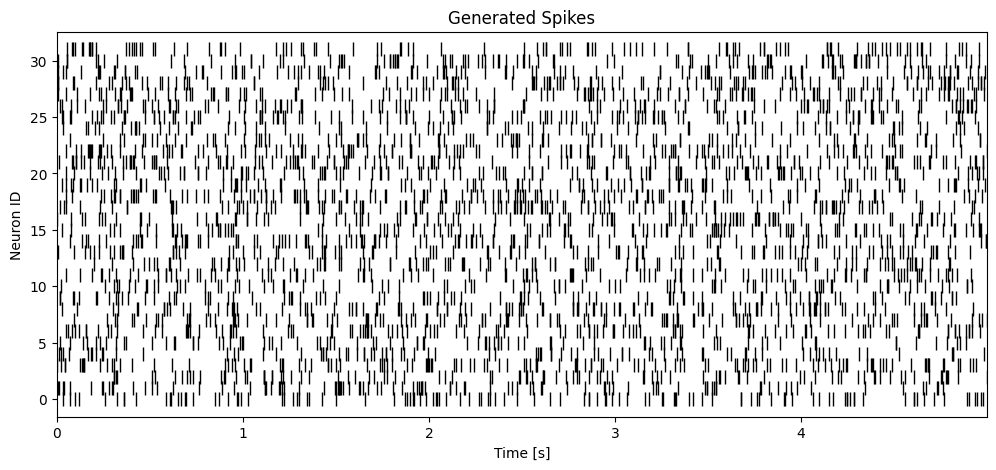

In [5]:
spikes = nm.test_data.inhomogenous_poisson_spikes(rates, 0.001)

ids = np.unique(spikes[:,0])

fig, ax = plt.subplots(1,1,figsize=(12, 5))
for id in ids:
    mask = spikes[:,0] == id
    spike_times = spikes[mask,1]
    ax.plot(spike_times, np.ones_like(spike_times)*id, '|', color='k', markersize=10)

ax.set_xlabel('Time [s]')
ax.set_ylabel("Neuron ID")
ax.set_title("Generated Spikes")
ax.set_xlim(0,t.max())
plt.show()

Follow analysis of https://www.nature.com/articles/s41593-019-0555-4

Bin spikes in windows of size 30ms

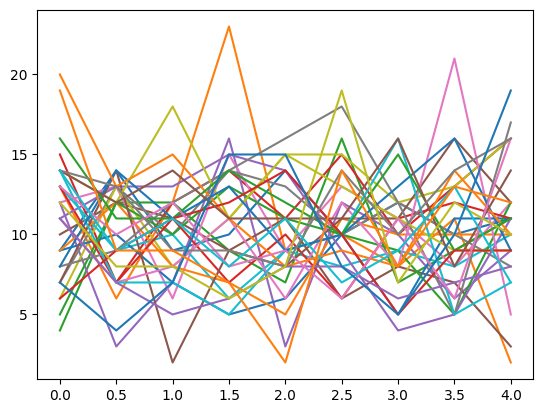

In [6]:
delta_t = 0.5 # 0.03
sd_t = 0.5    #0.05
counts, _, time = np.histogram2d(spikes[:,0], spikes[:,1],bins=[np.arange(N+1),np.arange(0,t.max(),delta_t)])
plt.plot(time[:-1], counts.T);

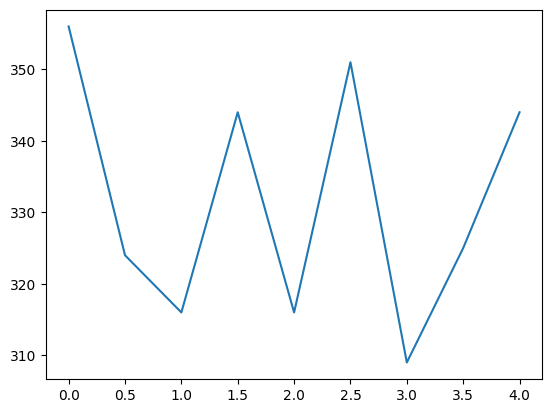

In [7]:
plt.plot(time[:-1], np.sum(counts.T, axis=1));

Now make square root transform

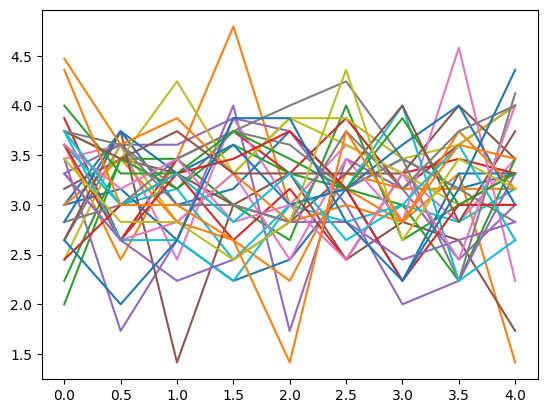

In [8]:
sqcounts = np.sqrt(counts)
plt.plot(time[:-1], sqcounts.T);

and apply Gaussian filter (with s.d. of 50ms)

(32, 9)


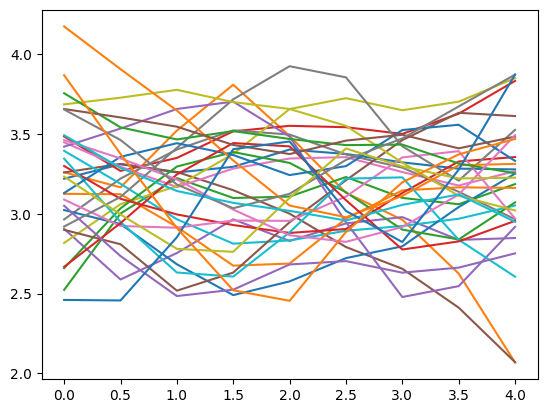

In [9]:
from scipy.ndimage import gaussian_filter1d
print(sqcounts.shape)
sd=sd_t/delta_t
signal = gaussian_filter1d(sqcounts, sigma=sd, axis=1)
plt.plot(time[:-1], signal.T);

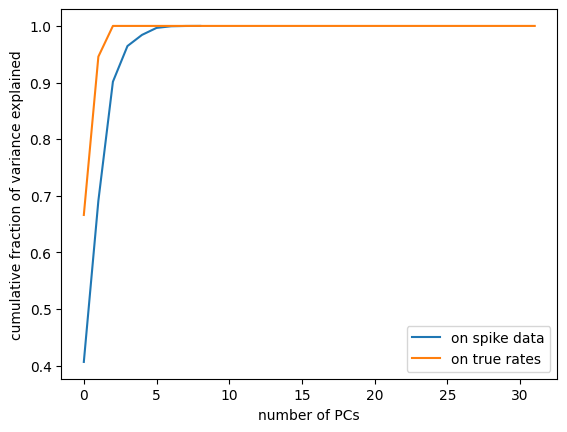

In [17]:
pca = PCA()
# print(signal.shape)
pca.fit(signal)
# print(pca.explained_variance_ratio_)
# print(pca.singular_values_)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='on spike data')
plt.plot(np.cumsum(pca_orig.explained_variance_ratio_), label='on true rates')
plt.xlabel('number of PCs')
plt.ylabel('cumulative fraction of variance explained')
plt.legend()